In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import random
import numpy as np
import pandas as pd
import os
# %load_ext autoreload
# %autoreload 2

In [2]:
train_data = pd.read_parquet('../../../train_v1_remove.parquet')
test_data  = pd.read_parquet('../../../test_v1_remove.parquet')

In [3]:
features = set(list(train_data.columns))
features.remove("CI_HOUR")
features = list(features)

In [4]:
categoical_list = []
numerical_list = []
for idx, column in enumerate(train_data.columns):
    if ("ARI_CO" in column) or ("ARI_PO" in column) or ("FLAG" in column) or ("SHIP_TYPE_CATEGORY" in column): 
        categoical_list.append(idx)
    else:
        numerical_list.append(idx)
print(categoical_list)
print(numerical_list)

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 2

In [5]:
def make_mixed_classification(train_data):
    cat_col_names = []
    num_col_names = []
    for idx, column in enumerate(train_data.columns):
        if ("ARI_CO" in column) or ("ARI_PO" in column) or ("FLAG" in column) or ("SHIP_TYPE_CATEGORY" in column): 
            cat_col_names.append(column)
        else:
            num_col_names.append(column)
    return train_data, cat_col_names, num_col_names

def print_metrics(y_true, y_pred, tag):
    if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if y_true.ndim>1:
        y_true=y_true.ravel()
    if y_pred.ndim>1:
        y_pred=y_pred.ravel()
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred)
    print(f"{tag} Acc: {val_acc} | {tag} F1: {val_f1}")

In [6]:
data, cat_col_names, num_col_names = make_mixed_classification(train_data)
# train, test = train_test_split(data, test_size=0.2, random_state=42)
train, val = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

In [9]:
data_config = DataConfig(
    target=['CI_HOUR'], #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=32768, # 기존엔 1024
    max_epochs=500,
    accelerator="gpu", # can be 'cpu','gpu', 'tpu', or 'ipu' 
    devices=1
)
optimizer_config = OptimizerConfig()

# DEPRECATED
# prediction head is defined separately now and head & head_config will be made
# mandatory in future releases
# model_config = CategoryEmbeddingModelConfig(
#     task="classification",
#     layers="1024-512-512",  # Number of nodes in each layer
#     activation="LeakyReLU", # Activation between each layers
#     learning_rate = 1e-3
# )

head_config = LinearHeadConfig(
    layers="", # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming"
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

from torchmetrics.functional  import mean_absolute_error, mean_squared_error

# mae = MeanAbsoluteError()
# mse = MeanSquaredError()

model_config = CategoryEmbeddingModelConfig(
    task="regression",
    layers="64-32-16", # Number of nodes in each layer
    activation="LeakyReLU", # Activation between each layers
    dropout=0.1,
    initialization="kaiming",
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    learning_rate = 1e-3,
    metrics=["mean_absolute_error", "mean_squared_error"]
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

import torch.nn as nn

huber_loss = nn.HuberLoss()

2023-10-23 16:23:02,156 - {pytorch_tabular.tabular_model:105} - INFO - Experiment Tracking is turned off


In [10]:
# 15분
tabular_model.fit(train=train, validation=val, loss=huber_loss)

Global seed set to 42
2023-10-23 16:23:04,935 - {pytorch_tabular.tabular_model:473} - INFO - Preparing the DataLoaders
2023-10-23 16:23:05,162 - {pytorch_tabular.tabular_datamodule:290} - INFO - Setting up the datamodule for regression task
2023-10-23 16:23:07,247 - {pytorch_tabular.tabular_model:521} - INFO - Preparing the Model: CategoryEmbeddingModel
2023-10-23 16:23:07,939 - {pytorch_tabular.tabular_model:268} - INFO - Preparing the Trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-10-23 16:23:09,734 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_mean_absolute_error', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_mean_squared_error', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.0009120108393559097
Restoring states from the checkpoint path at /data/HD-AI-Challenge/CHJ/pytorch_tabular/.lr_find_0bb337d7-e9

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ custom_loss      │ HuberLoss                 │      0 │
│ 1 │ _backbone        │ CategoryEmbeddingBackbone │ 35.8 K │
│ 2 │ _embedding_layer │ Embedding1dLayer          │  1.5 K │
│ 3 │ head             │ LinearHead                │     17 │
└───┴──────────────────┴───────────────────────────┴────────┘

Trainable params: 37.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 37.3 K                                                                                               
Total estimated model params size (MB): 0

Output()

2023-10-23 16:28:05,266 - {pytorch_tabular.tabular_model:584} - INFO - Training the model completed
2023-10-23 16:28:05,267 - {pytorch_tabular.tabular_model:1258} - INFO - Loading the best model
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/cloud_io.py:33: LightningDeprecationWarning: `pytorch_lightning.utilities.cloud_io.get_filesystem` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_fabric.utilities.cloud_io.get_filesystem` instead.
  rank_zero_deprecation(


In [11]:
pred_df = tabular_model.predict(test_data)
pred_df.head(20)
len(pred_df)

Output()

220491

In [12]:
from tqdm.auto import tqdm
submission_df = pd.read_csv('../../../sample_submission.csv')
submission_df['CI_HOUR'] = pred_df['CI_HOUR_prediction'].values
submission_df["CI_HOUR"] = [i if i > 0 else 0.0 for i in pred_df['CI_HOUR_prediction'].values]
# submit.to_csv("csv/autogluon_v2_1.csv", index=False)

In [13]:
submission_df.to_csv('../../../tabnet_huberloss.csv', index=False)

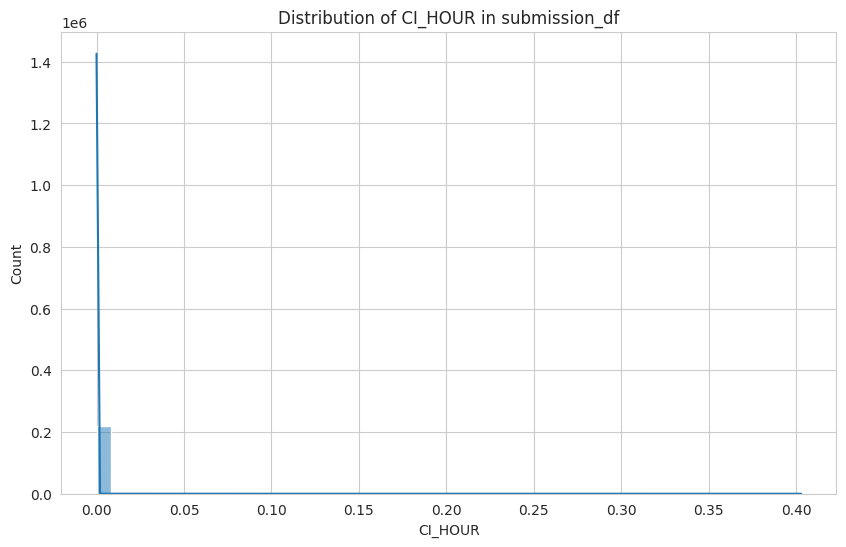

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set_style("whitegrid")

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(submission_df["CI_HOUR"], bins=50, kde=True)  # kde=True will also plot a density curve
plt.title('Distribution of CI_HOUR in submission_df')
plt.xlabel('CI_HOUR')
plt.ylabel('Count')
plt.show()